In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import itertools  # Import the itertools module
import GPy
from scipy.spatial import ConvexHull, Voronoi

# Guide and Ideas for Capstone Project - Function 8

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_8/initial_inputs.npy')
Y = np.load('initial_data/function_8/initial_outputs.npy')

print(X.shape[0])
print(Y.shape[0])

print(X)
print(Y)



40
40
[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.6049944525146120-0.2922150195593273-0.9084527476191498-0.3555062419884913-0.2016687192685087-0.5753380052826150-0.3103109513417007-0.7342813769904157
0.1780069588998261-0.5662226539934582-0.9948618446498820-0.2103250060528742-0.3201526568994505-0.7079087917386544-0.6353844889334020-0.1071316266051805
0.0090769766807290-0.8116261525080638-0.5205203597642096-0.0756866752142825-0.2651118251498523-0.0916516893992498-0.5924151454340054-0.3673202621902794
0.5060281642263985-0.6537301230139242-0.3634107791850698-0.1779810485319058-0.0937283043657330-0.1974253305870869-0.7558269002800702-0.2924723386565908
0.3599092642495875-0.2490756790115514-0.4959971701962457-0.7092149805738630-0.1149871946519401-0.2892069208178650-0.5572951508023158-0.5938817262561550
0.7788183442411031-0.0034194994840646-0.3379831296954995-0.5195277781785284-0.8209069931953403-0.5372466890767038-0.5513470979709983-0.6600320863046285
0.9086493218407411-0.0622496998191424-0.2382595456226729-0.7666035450099410-0.1323359623

In [5]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      427   1  0.605439  0.664755       NaN       NaN       NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN       NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN       NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363       NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905       NaN   
5     1      427   6  0.464312  0.339986  0.491438  0.749695  0.159201   
6     1      427   7  0.000000  0.268289  0.446722  0.095962  0.273324   
7     1      427   8  0.088905  0.288209  0.044306  0.256810  0.634647   
8     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
9     1      428   2  0.983984  0.999998       NaN       NaN       NaN   

         X6        X7       X8            Y  
0       NaN       NaN      NaN     0.007671  
1       NaN       NaN      NaN    -0.011315  
2       NaN       NaN      NaN    -0.146375  
3

In [6]:
## need to change the function name

pw_fn = pd_new[pd_new['Fn']==8]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.

## need to add addition feature based on the dimension
X_new_points = pw_fn[['X1','X2','X3','X4','X5','X6','X7','X8']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[8.89050e-02 2.88209e-01 4.43060e-02 2.56810e-01 6.34647e-01 4.59092e-01
  2.11743e-01 5.23620e-01]
 [1.23000e-04 2.22222e-01 2.22222e-01 2.22222e-01 6.66667e-01 6.66667e-01
  2.22222e-01 6.66667e-01]
 [8.27014e-01 4.24355e-01 2.22660e-01 9.23371e-01 9.33689e-01 6.25900e-02
  8.71635e-01 1.20479e-01]
 [2.00000e-01 2.00000e-01 2.00000e-01 0.00000e+00 9.90000e-01 4.00000e-01
  2.00000e-01 2.00000e-01]
 [5.82880e-02 1.65985e-01 1.32597e-01 2.12720e-02 8.56846e-01 5.27851e-01
  1.93914e-01 7.09151e-01]
 [6.10000e-02 8.19430e-02 2.11470e-02 6.29240e-02 7.06120e-01 7.51982e-01
  2.14847e-01 9.69102e-01]
 [0.00000e+00 3.33333e-01 0.00000e+00 3.33333e-01 6.66666e-01 3.33333e-01
  3.33333e-01 3.33333e-01]
 [5.55556e-01 7.99999e-01 7.99999e-01 8.22222e-01 5.55556e-01 8.99999e-01
  3.99999e-01 1.99999e-01]
 [5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01
  5.00000e-01 5.00000e-01]
 [2.00000e-01 2.00000e-01 2.00000e-01 0.00000e+00 9.90000e-01 4.00000e-01
  2.00000e-01 2.0

In [7]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[6.04994453e-01 2.92215020e-01 9.08452748e-01 3.55506242e-01
  2.01668719e-01 5.75338005e-01 3.10310951e-01 7.34281377e-01]
 [1.78006959e-01 5.66222654e-01 9.94861845e-01 2.10325006e-01
  3.20152657e-01 7.07908792e-01 6.35384489e-01 1.07131627e-01]
 [9.07697668e-03 8.11626153e-01 5.20520360e-01 7.56866752e-02
  2.65111825e-01 9.16516894e-02 5.92415145e-01 3.67320262e-01]
 [5.06028164e-01 6.53730123e-01 3.63410779e-01 1.77981049e-01
  9.37283044e-02 1.97425331e-01 7.55826900e-01 2.92472339e-01]
 [3.59909264e-01 2.49075679e-01 4.95997170e-01 7.09214981e-01
  1.14987195e-01 2.89206921e-01 5.57295151e-01 5.93881726e-01]
 [7.78818344e-01 3.41949948e-03 3.37983130e-01 5.19527778e-01
  8.20906993e-01 5.37246689e-01 5.51347098e-01 6.60032086e-01]
 [9.08649322e-01 6.22496998e-02 2.38259546e-01 7.66603545e-01
  1.32335962e-01 9.90243814e-01 6.88067822e-01 7.42495941e-01]
 [5.86371444e-01 8.80735726e-01 7.45020752e-01 5.46034849e-01
  9.64887799e-03 7.48991763e-01 2.30907070e-01 9.79156228e-02]


## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [8]:
next_query = np.random.uniform(size = 8)
print(format_query(next_query,6))

0.068767-0.790678-0.365278-0.462436-0.951631-0.822259-0.115517-0.133136


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [9]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
df['output'] = Y_updated

In [10]:
"""
# Save to CSV
csv_file_path = 'initial_data/function_8/function_8.csv'
df.to_csv(csv_file_path, index=False)

print(f"Dataset saved to '{csv_file_path}'")

"""

'\n# Save to CSV\ncsv_file_path = \'initial_data/function_8/function_8.csv\'\ndf.to_csv(csv_file_path, index=False)\n\nprint(f"Dataset saved to \'{csv_file_path}\'")\n\n'

In [11]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4         x5         x6  \
count  54.000000  54.000000  54.000000  54.000000  54.000000  54.000000   
mean    0.457480   0.429535   0.446843   0.405245   0.528287   0.460708   
std     0.321020   0.289244   0.301513   0.283837   0.288423   0.260380   
min     0.000000   0.003419   0.000000   0.000000   0.009649   0.022113   
25%     0.176614   0.200000   0.222332   0.155065   0.265264   0.258985   
50%     0.459583   0.378844   0.379438   0.371557   0.607395   0.427611   
75%     0.776238   0.637932   0.726319   0.656450   0.733288   0.663642   
max     0.985945   0.973980   0.998885   0.950000   0.990000   0.990244   

              x7         x8     output  
count  54.000000  54.000000  54.000000  
mean    0.506388   0.478314   8.179578  
std     0.273354   0.276332   1.170952  
min     0.014718   0.041956   5.592193  
25%     0.241859   0.201460   7.315029  
50%     0.505280   0.474430   8.101098  
75%     0.754113

## exploring the centre of the MEC

In [12]:
# Replace with the datapoints
points = X_updated  

# Creating the Voronoi diagram
try:
    vor = Voronoi(points)
except Exception as e:
    print("Error in computing Voronoi diagram:", e)
    raise

# Compute Convex Hull 
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty sphere 
max_radius = 0
center_of_max_sphere = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_sphere = vertex


# You can print the results or analyze them programmatically
if center_of_max_sphere is not None:
    print(f"Center of the largest empty sphere: {format_query(center_of_max_sphere,6)}")
    print("Radius of the largest empty sphere:", max_radius)
else:
    print("No empty sphere found within the convex hull.")
    

No empty sphere found within the convex hull.


## The best point is [0.058288, 0.165985, 0.132597, 0.021272, 0.856846, 0.527851, 0.193914, 0.709151]


In [15]:
# updated dataset
points = X_updated

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates
best_points = [0.058288, 0.165985, 0.132597, 0.021272, 0.856846, 0.527851, 0.193914, 0.709151]

# Define the threshold for each dimension
threshold = 0.2  # Example threshold value

# Calculate min and max values for each dimension based on the threshold
min_values = [x - threshold for x in best_points]
max_values = [x + threshold for x in best_points]

# Increase the number of samples significantly
num_samples = 100000  # Larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region.")

# The target point 
target_point = np.array(best_points)

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to", best_points, "are:")
print(closest_points)


The 10 closest points to [0.058288, 0.165985, 0.132597, 0.021272, 0.856846, 0.527851, 0.193914, 0.709151] are:
[[0.1754473  0.16194516 0.19119029 0.04283372 0.81032277 0.51601015
  0.11533894 0.64884864]
 [0.14751892 0.08083517 0.08940186 0.10392494 0.84669189 0.46142086
  0.23907399 0.77137678]
 [0.02274955 0.19178793 0.11811826 0.09792292 0.75064906 0.44705577
  0.2931076  0.68854966]
 [0.00460679 0.11249151 0.04476448 0.12879923 0.82130804 0.53317162
  0.31377978 0.65403824]
 [0.15449226 0.12029555 0.14782377 0.09862646 0.78542012 0.41573606
  0.27295833 0.76071121]
 [0.10812687 0.08809284 0.1282438  0.01355032 0.95174617 0.412461
  0.17244588 0.82347167]
 [0.14043682 0.22463447 0.04373478 0.12824994 0.87333541 0.57043552
  0.23009362 0.82133873]
 [0.10371546 0.16082398 0.09948688 0.17697217 0.94515866 0.51276888
  0.28565684 0.75976439]
 [0.18171889 0.17504341 0.16810407 0.02245512 0.99421065 0.53187905
  0.26743387 0.62161552]
 [0.11752934 0.11742979 0.09873883 0.08617864 0.788659

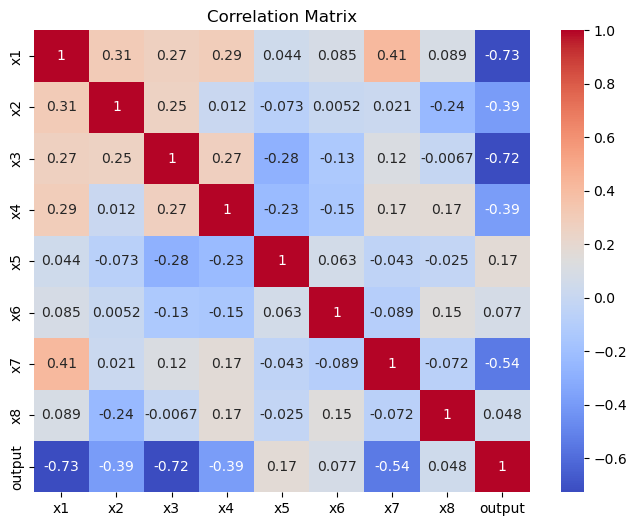

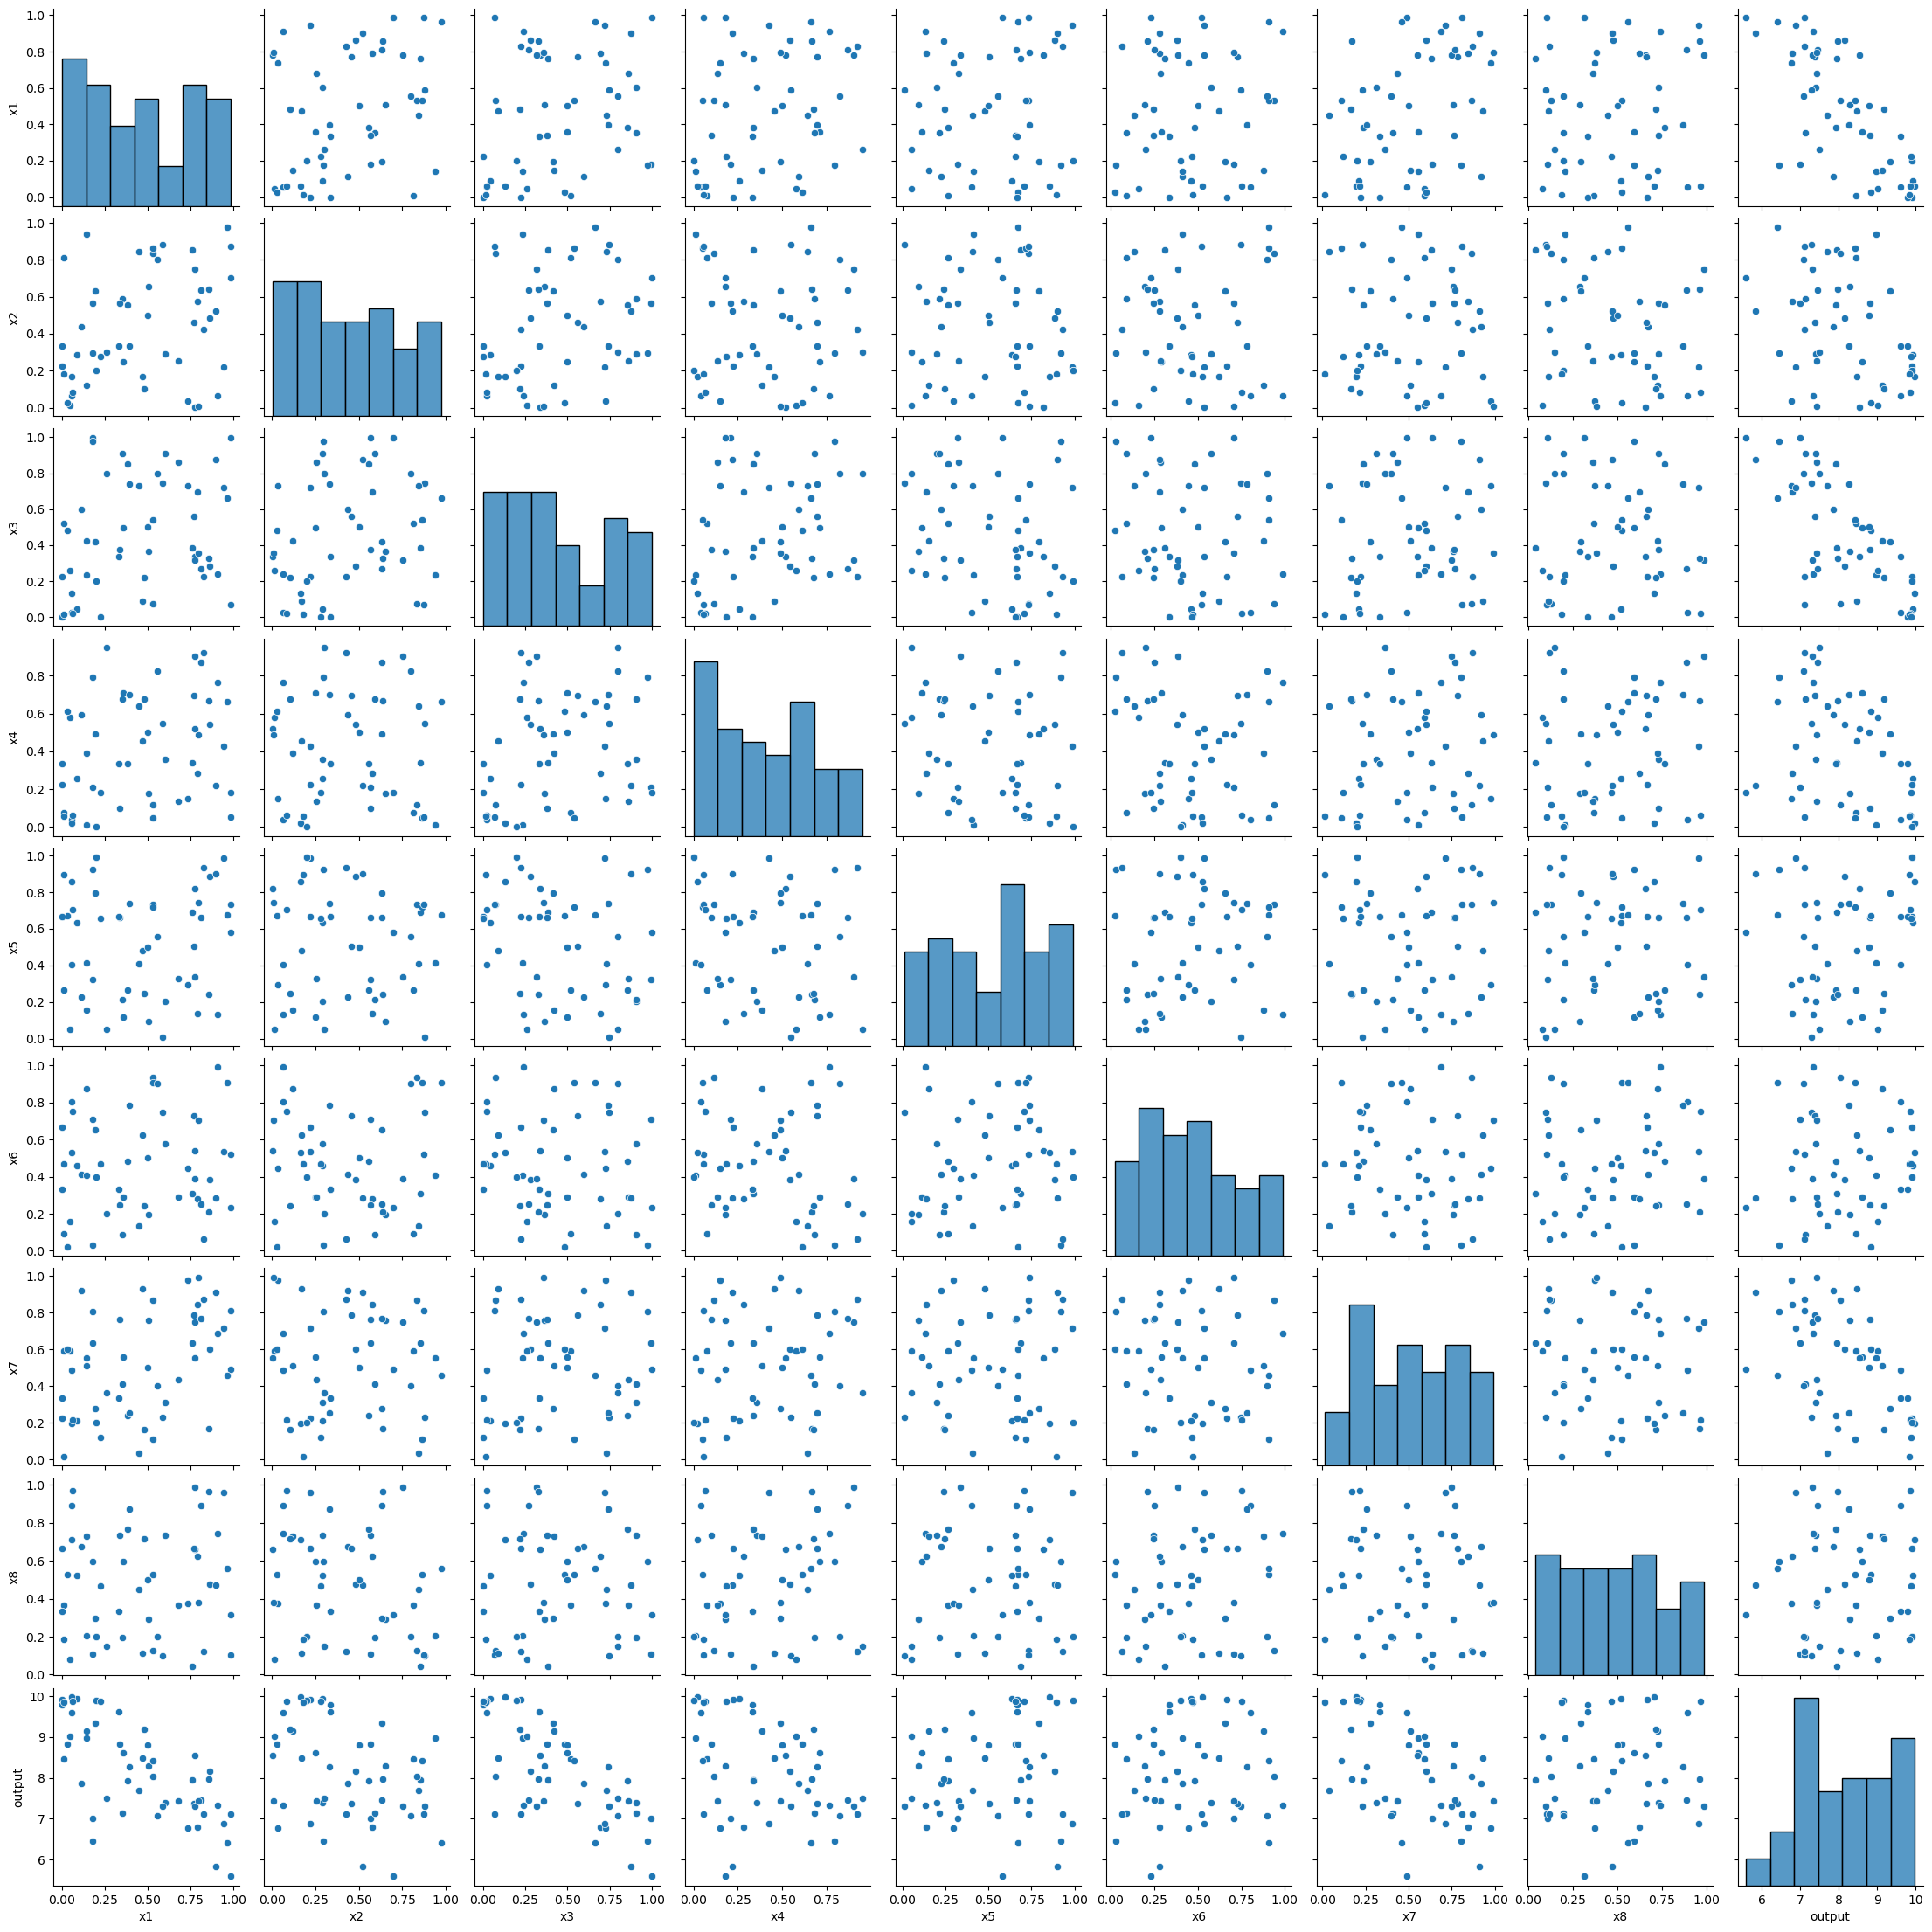

In [16]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [18]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: {'kernel__k1__constant_value': 0.008632008168602543, 'kernel__k2__length_scale': 0.0008629132190071856}
Log-marginal-likelihood: 8.442595671450974


In [19]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [20]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma

In [21]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

In [22]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

# Approach 2: Surrogate - using sklearn GP model train accumulatively

In [23]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
    #'k2__noise_level': loguniform(1e-3, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: {'kernel__k1__constant_value': 0.066904211664988, 'kernel__k2__length_scale': 0.14077923139972395}
Log-marginal-likelihood: 8.442595669051741


## Appoach 2: using sklearn GP model via random generated grid

Next query EI:  0.458520-0.859140-0.915932-0.306951-0.451129-0.911485-0.641956-0.824929
Next query PI:  0.120665-0.086587-0.059788-0.208952-0.989084-0.546739-0.214213-0.584151
Next query UCB:  0.120665-0.086587-0.059788-0.208952-0.989084-0.546739-0.214213-0.584151
MSE: 6.217868393728051e-18
R-squared: 1.0


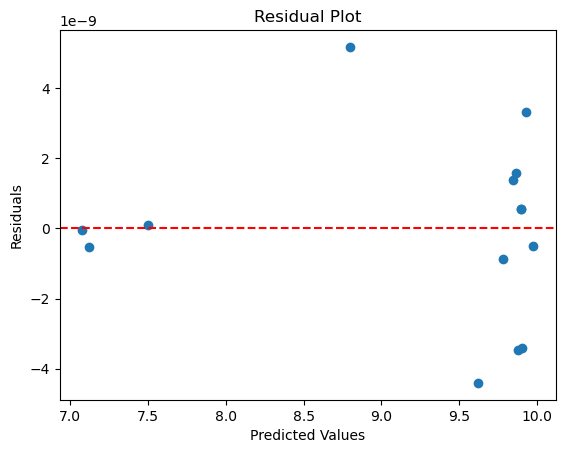

In [19]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 8  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 2  # For week 3, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

Next query EI:  0.140567-0.225240-0.021667-0.104559-0.762310-0.468636-0.121279-0.607585
Next query PI:  0.103715-0.160824-0.099487-0.176972-0.945159-0.512769-0.285657-0.759764
Next query UCB:  0.103715-0.160824-0.099487-0.176972-0.945159-0.512769-0.285657-0.759764
MSE: 6.2171779066122e-18
R-squared: 1.0


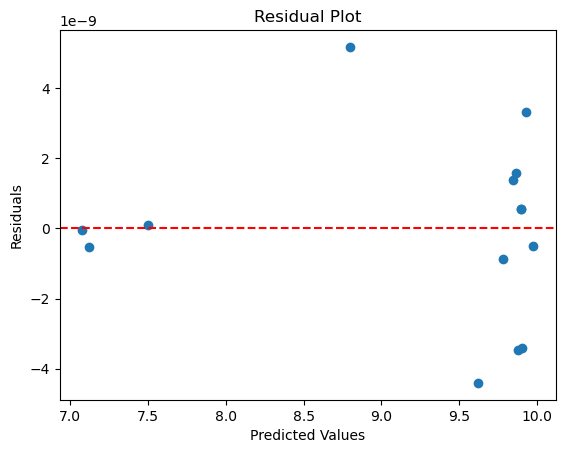

In [24]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 2  # For week 3, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

## Aproach 3:  a Sparse Gaussian Process model

In [20]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |               value  |  constraints  |  priors
  variance     |   7.104378205487471  |      +ve      |        
  lengthscale  |  2.6854606758285766  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.06045073  |      +ve      |        
MSE on validation set: 2.375173094721612


Next query EI:  0.030210-0.210713-0.002530-0.237057-0.656386-0.413161-0.060845-0.409952
Next query PI:  0.030210-0.210713-0.002530-0.237057-0.656386-0.413161-0.060845-0.409952
Next query UCB:  0.006255-0.295158-0.009778-0.297197-0.558071-0.531697-0.001494-0.630989
MSE: 0.03927888545082766
R-squared: 0.9663224571349461


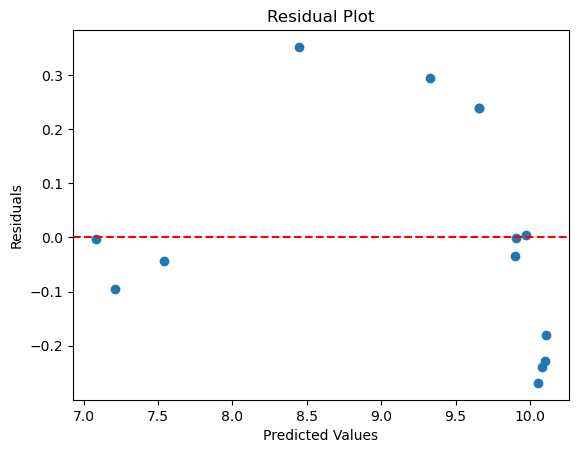

In [21]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

## Weekly update steps: 
1. Update Your Dataset: After receiving the output from your first query, update your dataset (X_sample and Y_sample) with this new information.
X_sample: This should include the 8-dimensional input you submitted.
Y_sample: Update this with the output you received corresponding to the input.

python code
# Example: Adding new data point to the dataset
# Assume new_point_X is your submitted query and new_point_Y is the received output
new_point_X = np.array([x1, x2, x3, x4, x5, x6, x7, x8])  # Replace with actual values
new_point_Y = received_output  # Replace with the actual output received
X_sample = np.vstack((X_sample, new_point_X))
Y_sample = np.append(Y_sample, new_point_Y)

2. Update the Gaussian Process Model: Re-train your Gaussian Process Regressor with the updated dataset. This allows the model to learn from the new data point.

python code
gpr.fit(X_sample, Y_sample)

3. Generate the Next Query Point: Use your acquisition function (UCB in this case) to select the next query point. This point is where the model predicts the highest potential based on the current understanding of the function.

python code
X_next = generate_point_uniformly(bounds)

4. Submit the New Query: Submit this new query and wait for the output. This step will be repeated every week.

python code
# Use your mechanism for submitting the query
submit_query_and_receive_output(X_next)

5. Print or Log Information
For tracking purposes, you might want to log the query along with its kappa value and any other relevant information.

python code
formatted_query = "-".join(f"{x:.6f}" for x in X_next)
print(f"Week {week + 1}, Submitted Query: {formatted_query}, Kappa: {kappa}")

6. Repeat the Process
Continue this process for each subsequent week. Remember to adjust kappa if you are using a dynamic strategy for exploration-exploitation balance.

Additional Considerations:
Exploration vs. Exploitation: Early in the process, focus more on exploration to understand the function's behavior. As we progress, shift towards exploitation.
Learning from Outputs: Each output informs the model about the function's landscape, improving its predictions over time.
Adjustments Based on Performance: If we notice certain trends or behaviors in the outputs, we may want to adjust your strategy accordingly.
By following these steps, we'll be able to iteratively refine our understanding of the unknown function and hopefully converge towards optimal input values that maximize the output.

In [12]:
# Define the UCB surrogate acquisition function
def upper_confidence_bound(X, X_sample, Y_sample, gpr, kappa):
    mu, sigma = gpr.predict(X, return_std=True)
    return mu + kappa * sigma

# Initialize your Gaussian process
gpr = GaussianProcessRegressor()

# initial data
X_sample = X
Y_sample = Y
print(X.shape[0])
print(X_sample.shape[0])
print(Y_sample.shape[0])


# Define the number of iterations for the Bayesian Optimization
N_ITERATIONS = 10  # start from 10

# Define the function to generate candidate points for evaluation
def generate_points_uniformly(num_points, bounds):
    # bounds should be a list of tuples defining the lower and upper bounds for each dimension
    return np.random.uniform(bounds[:, 0], bounds[:, 1], (num_points, bounds.shape[0]))

# Define the actual objective function that you're trying to optimize
def objective_function(X):
    # This function should take a single point X and return its objective value
    # For example, this could be a call to a simulator, a real-world experiment, or a complex calculation
    pass

# Set the bounds for each dimension of your input space
bounds = np.array([[0, 1]*8)

# Kappa parameters for exploration-exploitation balance
kappa_initial = 5.0
kappa_decay = 0.9
min_kappa = 0.1

# Define the number of points to generate
NUM_POINTS = 50  # For example, define how many points to generate

# Bayesian Optimization loop
for n in range(N_ITERATIONS):
    # Decay the kappa value over iterations
    kappa = max(kappa_initial * (kappa_decay ** n), min_kappa)
                   
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Generate a set of points to predict the UCB over
    # Pass the number of points and bounds to the function
    X_candidates = generate_points_uniformly(NUM_POINTS, bounds)

    # Select the point that maximizes UCB
    UCB_values = upper_confidence_bound(X_candidates, X_sample, Y_sample, gpr, kappa)
    X_next = X_candidates[np.argmax(UCB_values)]

    # Obtain the next sample from the objective function
    Y_next = objective_function(X_next)

    # Add the new sample to our existing samples
    # Ensure X_next is reshaped to match the feature dimension
    # Ensure Y_next is a scalar before appending
    X_sample = np.vstack((X_sample, X_next.reshape(1, -8)))  # Assuming 'DIM' is the number of features
    Y_sample = np.append(Y_sample, Y_next)

   
    

40
40
40


In [ ]:
# Adapting the Exploration Parameter Over Time
# To adjust over time,

In [ ]:
# Defining the Search Space: Specify the range or possible values for each of the six hyperparameters.

search_space = [
    Integer(100, 1000, name='n_estimators'),  # Number of trees
    Integer(1, 100, name='max_depth'),        # Maximum depth of the trees
    Real(0.01, 1.0, 'uniform', name='min_samples_split'),  # Minimum number of samples required to split an internal node
    # ... other RandomForestClassifier parameters ...
]

In [ ]:
# Define the evaluation function
@use_named_args(search_space)
def evaluate_model(**params):
    # Set the hyperparameters in your model
    model = RandomForestClassifier()  # Replace with your model
    model.set_params(**params)

    # Evaluate your model (e.g., using cross-validation)
    scores = cross_val_score(model, X, Y, cv=5)  # Replace X and y with your data
    return -scores.mean()  # Minimize negative accuracy for maximization

# Perform the optimization
result = gp_minimize(evaluate_model, search_space, n_calls=20, random_state=0)

# Results
print("Best score achieved: {}".format(-result.fun))
print("Best parameters: {}".format(result.x))

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel
# Define the kernel to be used in the Gaussian Process
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(5), nu=2.5) + WhiteKernel(noise_level=1)

# Instantiate a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel)

# Fit the Gaussian Process to the initial data
gp.fit(X, Y)

# After fitting, you can check the learned length scales
length_scale = gp.kernel_.k1.get_params()["k2__length_scale"]
print("Learned length scales:", length_scale)

In [ ]:
from scipy.stats import norm
#Acquisition Function for Exploration-Exploitation Trade-off

# Define the Upper Confidence Bound (UCB) acquisition function
def upper_confidence_bound(gp, x, kappa=1.96):
    x = np.atleast_2d(x)
    mean, std = gp.predict(x, return_std=True)
    return mean - kappa * std  # Minus because we want to minimize the adverse reaction

# Define the acquisition function
def expected_improvement(X, X_sample, gp, xi=0.01):
    '''
    Computes the Expected Improvement at points X based on existing samples
    X_sample using a Gaussian process surrogate model gp.
    '''
    mu_sample_opt = np.max(gp.predict(X_sample))

    mu, sigma = gp.predict(X, return_std=True)
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

# Define a space where to evaluate the acquisition function
X_space = np.random.uniform(0, 1, size=(100, 5))  # 100 random points in 5D space

# Compute the EI on the defined space
EI = expected_improvement(X_space, X, gp)

# Find the point with the highest EI
X_next = X_space[np.argmax(EI)]

# Output the next sampling point
print(f"The next point to sample is at: {X_next}")

In [ ]:
#Hyperparameter Tuning for the Machine Learning Model
# We'll use a Random Search approach, which is often more efficient than Grid Search and can be implemented using Scikit-Learn.

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor
model = RandomForestRegressor()

# Define the hyperparameter space to search
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': [None, 'sqrt', 'log2'],  # Remove 'auto'
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the random search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=5, verbose=1, random_state=42)

# Reshape y_train to be a 1D array
y_train_reshaped = Y.ravel()

# Fit the model
random_search.fit(X, y_train_reshaped)

# Best parameters
print("Best Parameters:", random_search.best_params_)

In [ ]:
# Configure the model with the best parameters
rf_best_model = RandomForestRegressor(n_estimators=100,
                                   min_samples_split=2,
                                   min_samples_leaf=1)

# Train the model with the best parameters on the full training data
rf_best_model.fit(X, Y.ravel())

# Your model is now ready to be used for predictions or further evaluation

In [ ]:
def surrogate_objective_function(x):
    return rf_best_model.predict([x])[0]

In [ ]:
from scipy.optimize import basinhopping

# Initial guess for hyperparameters
x0 = [0.15278313, 0.00591092, 0.6040595,  0.83876021, 0.23738734]

# Set up the optimizer with the surrogate objective function
minimizer_kwargs = {"method": "BFGS"}
result = basinhopping(surrogate_objective_function, x0, minimizer_kwargs=minimizer_kwargs, niter=100)

# Result
print("Optimized hyperparameters: x = {}, surrogate output = {}".format(result.x, result.fun))
